In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/datasets"

/content/drive/MyDrive/datasets


In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import re
import time  # Import time module to track training duration

# Function to clean and preprocess text data
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Function to process each chunk and return a DataFrame
def process_chunk(chunk):
    # Preprocess the review text
    chunk['cleaned_text'] = chunk['text'].apply(preprocess_text)

    # Assign sentiment labels based on stars rating
    def get_sentiment_label(stars):
        if stars >= 4:
            return 'Positive'
        elif stars == 3:
            return 'Neutral'
        else:
            return 'Negative'

    chunk['sentiment'] = chunk['stars'].apply(get_sentiment_label)

    return chunk[['cleaned_text', 'sentiment']]

# Initialize an empty DataFrame to hold all processed data
all_data = pd.DataFrame()




In [ ]:
# Read the JSON data in chunks
df = pd.read_json('yelp_academic_dataset_review.json', lines=True, chunksize=30000)
df = next(df)
processed_chunk = process_chunk(df)
all_data = pd.concat([all_data, processed_chunk], ignore_index=True)

In [ ]:
all_data.shape

(30000, 2)

In [ ]:
all_data.head(2)

,cleaned_text,sentiment
0,if you decide to eat here just be aware it is ...,Neutral
1,ive taken a lot of spin classes over the years...,Positive


In [ ]:
# review_aggregates = all_data.groupby('business_id').agg({
#     'stars': 'mean',
#     'review_id': 'count',
#     'useful': 'sum',
#     'funny': 'sum',
#     'cool': 'sum'
# }).reset_index()

In [ ]:
# df=review_aggregates
# review_aggregates.shape

In [ ]:

# Prepare features and labels
X = all_data['cleaned_text']
y = all_data['sentiment']

# Step 1: Split the Data (Ensure test set has >5000 samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Test Set Size: {len(X_test)} samples")  # Ensure >5000 samples

# Step 2: Vectorization

# Model 1: CountVectorizer (Unigram)
count_vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=20000)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Model 2: TF-IDF Vectorizer (Unigram + Bigram)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Test Set Size: 7500 samples


In [ ]:


# Step 3: Train SVM Models

# Model 1: SVM with Count Vectors
svm_count = SVC(kernel='linear', random_state=42)

# Measure training time for Count Vector SVM
start_time_count = time.time()
svm_count.fit(X_train_count, y_train)
training_time_count = time.time() - start_time_count

# Model 2: SVM with TF-IDF Vectors
svm_tfidf = SVC(kernel='linear', random_state=42)

# Measure training time for TF-IDF SVM
start_time_tfidf = time.time()
svm_tfidf.fit(X_train_tfidf, y_train)
training_time_tfidf = time.time() - start_time_tfidf

# Step 4: Evaluate Models

# Predictions using Count Vectors
y_pred_count = svm_count.predict(X_test_count)
print("SVM with Count Vectors - Classification Report")
print(classification_report(y_test, y_pred_count))
print(f"Accuracy: {accuracy_score(y_test, y_pred_count)}")
print(f"Training Time (Count Vectors SVM): {training_time_count:.2f} seconds")

# Predictions using TF-IDF Vectors
y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)
print("\nSVM with TF-IDF Vectors - Classification Report")
print(classification_report(y_test, y_pred_tfidf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf)}")
print(f"Training Time (TF-IDF SVM): {training_time_tfidf:.2f} seconds")

# Print model configurations
print("\nModel Configurations:")
print(f"SVM Count Vectors Config: {svm_count.get_params()}")
print(f"SVM TF-IDF Config: {svm_tfidf.get_params()}")


SVM with Count Vectors - Classification Report
              precision    recall  f1-score   support

    Negative       0.69      0.76      0.72      1397
     Neutral       0.36      0.32      0.34       852
    Positive       0.91      0.90      0.90      5251

    accuracy                           0.81      7500
   macro avg       0.65      0.66      0.65      7500
weighted avg       0.80      0.81      0.80      7500

Accuracy: 0.8068
Training Time (Count Vectors SVM): 551.56 seconds

SVM with TF-IDF Vectors - Classification Report
              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81      1397
     Neutral       0.54      0.27      0.36       852
    Positive       0.89      0.97      0.93      5251

    accuracy                           0.86      7500
   macro avg       0.75      0.68      0.70      7500
weighted avg       0.84      0.86      0.84      7500

Accuracy: 0.8577333333333333
Training Time (TF-IDF SVM): 465.23 seconds

Mo

In [ ]:

# Non-linear SVM with RBF Kernel for Count Vectors
svm_rbf_count = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

start_time_count = time.time()  # Start timing
svm_rbf_count.fit(X_train_count, y_train)  # Train the model
end_time_count = time.time()  # End timing

# Predictions for Count Vector Model
y_pred_count_rbf = svm_rbf_count.predict(X_test_count)

print("\nSVM with RBF Kernel (Count Vectors) - Classification Report")
print(classification_report(y_test, y_pred_count_rbf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_count_rbf)}")
print(f"Training Time (RBF Kernel with Count Vectors): {end_time_count - start_time_count:.2f} seconds")

# Non-linear SVM with RBF Kernel for TF-IDF Vectors
svm_rbf_tfidf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

start_time_tfidf = time.time()  # Start timing
svm_rbf_tfidf.fit(X_train_tfidf, y_train)  # Train the model
end_time_tfidf = time.time()  # End timing

# Predictions for TF-IDF Vector Model
y_pred_tfidf_rbf = svm_rbf_tfidf.predict(X_test_tfidf)

print("\nSVM with RBF Kernel (TF-IDF Vectors) - Classification Report")
print(classification_report(y_test, y_pred_tfidf_rbf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf_rbf)}")
print(f"Training Time (RBF Kernel with TF-IDF Vectors): {end_time_tfidf - start_time_tfidf:.2f} seconds")


# Print model configurations
print("\nModel Configurations:")
print(f"SVM Count Vectors Config: {svm_rbf_count.get_params()}")
print(f"SVM TF-IDF Config: {svm_tfidf.get_params()}")


SVM with RBF Kernel (Count Vectors) - Classification Report
              precision    recall  f1-score   support

    Negative       0.79      0.71      0.75      1397
     Neutral       0.59      0.08      0.14       852
    Positive       0.84      0.98      0.90      5251

    accuracy                           0.83      7500
   macro avg       0.74      0.59      0.60      7500
weighted avg       0.80      0.83      0.79      7500

Accuracy: 0.8269333333333333
Training Time (RBF Kernel with Count Vectors): 360.10 seconds

SVM with RBF Kernel (TF-IDF Vectors) - Classification Report
              precision    recall  f1-score   support

    Negative       0.82      0.79      0.81      1397
     Neutral       0.61      0.15      0.24       852
    Positive       0.87      0.98      0.92      5251

    accuracy                           0.85      7500
   macro avg       0.77      0.64      0.66      7500
weighted avg       0.83      0.85      0.82      7500

Accuracy: 0.851333333333

Evaluation for SVM with RBF Kernel (Count Vectors):

Confusion Matrix:
[[ 985   25  387]
 [ 175   67  610]
 [  80   21 5150]]
F1 Score (Macro Average): 0.5965
F1 Score (Weighted Average): 0.7876
Accuracy: 0.8269
AUC Score: 0.8506


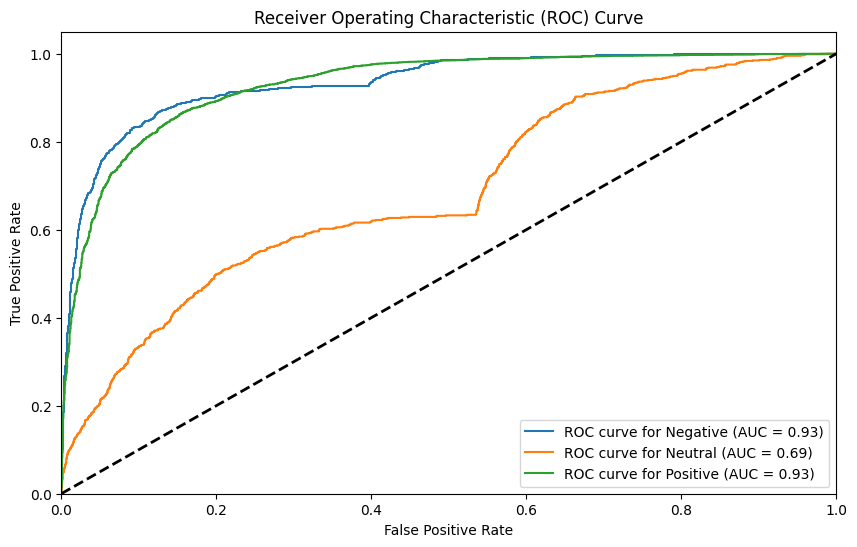


Evaluation for SVM with RBF Kernel (TF-IDF Vectors):

Confusion Matrix:
[[1102   55  240]
 [ 164  130  558]
 [  70   28 5153]]
F1 Score (Macro Average): 0.6569
F1 Score (Weighted Average): 0.8221
Accuracy: 0.8513
AUC Score: 0.8805


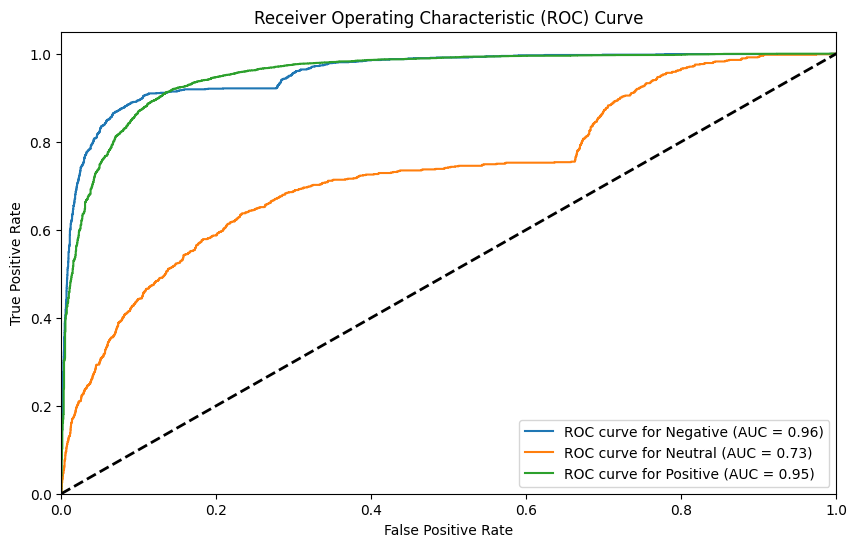

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to print Confusion Matrix, F1 Scores, AUC, and Accuracy
def evaluate_model(model, X_test, y_test, y_pred):
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['Negative', 'Neutral', 'Positive'])
    print("\nConfusion Matrix:")
    print(cm)

    # F1 Scores for Each Class (Macro Average)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score (Macro Average): {f1_macro:.4f}")
    print(f"F1 Score (Weighted Average): {f1_weighted:.4f}")

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # AUC Calculation (One-vs-Rest strategy for multi-class)
    y_test_bin = pd.get_dummies(y_test, drop_first=False).values
    y_pred_prob = model.decision_function(X_test)
    auc_score = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr')
    print(f"AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate RBF SVM with Count Vectors
print("Evaluation for SVM with RBF Kernel (Count Vectors):")
evaluate_model(svm_rbf_count, X_test_count, y_test, y_pred_count_rbf)

# Evaluate RBF SVM with TF-IDF Vectors
print("\nEvaluation for SVM with RBF Kernel (TF-IDF Vectors):")
evaluate_model(svm_rbf_tfidf, X_test_tfidf, y_test, y_pred_tfidf_rbf)
